In [1]:
import os
import glob
import pickle
import datetime
import numpy as np
from tqdm.notebook import tqdm_notebook, trange
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import *
from circlesym import *

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'

In [3]:
uniques, VisAO_science, VisAO_darks = sortData(datadir, instrument='VisAO', filesdeep='*\\*\\', returntab=True)

  0%|                                                                              | 15/33363 [00:00<03:46, 147.09it/s]

sorting individual images


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 288.13it/s]

sorting unique datasets into lists


In [4]:
# data takes a long time to sort so pickle result
filename = 'visao_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_science,outfile)
outfile.close()

filename = 'visao_uniques.pkl'
outfile = open(filename,'wb')
pickle.dump(uniques,outfile)
outfile.close()

filename = 'visao_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_darks,outfile)
outfile.close()

In [3]:
# read in pickle
infile = open('visao_science.pkl','rb')
VisAO_science = pickle.load(infile)
infile.close()

infile = open('visao_uniques.pkl','rb')
uniques = pickle.load(infile)
infile.close()

infile = open('visao_darks.pkl','rb')
VisAO_darks = pickle.load(infile)
infile.close()

In [6]:
# sorts dark fields into a subfolder in their directory named dark
VisAO_new_darks = []
for i in range(len(VisAO_darks)):
    dataset = VisAO_darks[i]
    new_darkset = []
    for dark_im in dataset:
        imname = dark_im.split('\\')[-1]
        newroot = dark_im.replace(dark_im.split('\\')[-1], 'dark\\')
        if os.path.exists(newroot):
            pass
        else:
            os.mkdir(newroot)
        newpath = newroot+imname
        try:
            os.rename(dark_im, newpath)
        except FileNotFoundError:
            pass
        new_darkset.append(newpath)
    VisAO_new_darks.append(new_darkset)

filename = 'visao_new_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_darks,outfile)
outfile.close()

In [7]:
# introduce median combine function
def mediancombine(filelist, norm=False):
    '''
    median combine frames, can norm for flats or not
    '''
    # gather some information about the images
    n = len(filelist)
    first_frame_data = fits.getdata(filelist[0])
    imsize_y, imsize_x = first_frame_data.shape
    # construct an empty cube with proper dimensions
    fits_stack = np.zeros((imsize_y, imsize_x, n))
    # fill cube with images in filelist
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        if norm is True:
            im /= np.nanmedian(im)
        fits_stack[:, :, ii] = im
    # take the median combination of the images along the
    # correct axis (we made this the 3rd axis of our image cube)
    med_frame = np.nanmedian(fits_stack, axis=2)
    return med_frame

In [8]:
# sorts science images into a subfolder in their directory named science
VisAO_new_science = []
for i in trange(len(VisAO_science)):
    dataset = VisAO_science[i]
    exptimes = []
    # print('checking exp times')
    for im in tqdm_notebook(dataset):
        try:
            im_expt = fits.getheader(im)['EXPTIME']
            if im_expt not in exptimes:
                exptimes.append(im_expt)
        except FileNotFoundError:
            pass
                
    for expt in tqdm_notebook(exptimes):
        ims_with_expt = []
        ims_with_expt_new_path = []
        for im in dataset:
            try:
                im_expt = fits.getheader(im)['EXPTIME']
                if im_expt == expt:
                    ims_with_expt.append(im)
            except FileNotFoundError:
                pass
            

        for sci_im in tqdm_notebook(ims_with_expt):
            imname = sci_im.split('\\')[-1]
            newroot = sci_im.replace(sci_im.split('\\')[-1], 'science'+str(round(expt, 5))+'s\\')
            if os.path.exists(newroot):
                # print('folder ', newroot, 'exists')
                pass
            else:
                # print('creating folder ', newroot)
                os.mkdir(newroot)
            newpath = newroot+imname
            try:
                os.rename(sci_im, newpath)
            except FileNotFoundError:
                pass
            ims_with_expt_new_path.append(newpath)
        VisAO_new_science.append(ims_with_expt_new_path)

filename = 'visao_new_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_science,outfile)
outfile.close()

In [4]:
infile = open('visao_new_science.pkl','rb')
VisAO_new_science = pickle.load(infile)
infile.close()

infile = open('visao_new_darks.pkl','rb')
VisAO_new_darks = pickle.load(infile)
infile.close()

In [10]:
nights = glob.glob(datadir+'\\**\\')#, recursive=True)
obs = []
for night in nights:
    runs = glob.glob(night+'\\**\\')
    for run in runs:
        obs.append(run)

darks = []
obs2 = []
for ob in obs:
    exptsets = glob.glob(ob+'science*\\*fits*')
    if len(exptsets) != 0:
        obs2.append(exptsets)
        darkset = glob.glob(ob+'dark*\\*fits*')
        darks.append(darkset)

In [11]:
# write master dark for each observation
master_darks = []
master_dark_paths = []
for obs in tqdm_notebook(darks):
    darkim = obs[0]
    oldheader = fits.getheader(darkim)
    oldroot = darkim.replace('dark\\'+darkim.split('\\')[-1], '\\')
    newpath = oldroot+'MasterDark'+str(oldheader['EXPTIME'])+'s'+str(oldheader['V47GAIN'])+'.fit'
    master_dark_paths.append(newpath)
    master_dark = mediancombine(obs)
    master_darks.append(master_dark)
    fits.writeto(newpath, master_dark, oldheader, overwrite=True)

In [12]:
# dark subtract and save as cube
for i in trange(len(obs2)):
    sci_ims = obs2[i]
    dark_ims = darks[i]
    dark = master_darks[i]
    firstim = sci_ims[0]
    first_frame_data, firstheader = fits.getdata(firstim, header=True)
    date = firstheader['DATE-OBS'].split('T')[0]
    targ = firstheader['OBJECT']
    expt = firstheader['EXPTIME']
    newroot = firstim.replace('\\science'+str(round(expt, 5))+'s\\'+firstim.split('\\')[-1], '\\')
    newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'
    
    n = len(sci_ims)
    imsize_y, imsize_x = first_frame_data.shape
    fits_stack = np.zeros((n, imsize_y, imsize_x))
    for ii in range(0, n):
        im = fits.getdata(sci_ims[ii])
        fits_stack[ii, :, :] = im - dark
    
    # delete raw data to save space
    for im in sci_ims:
        os.remove(im)
    for dark in dark_ims:
        os.remove(dark)
    
    fits.writeto(newpath, fits_stack, firstheader, overwrite=True)

KeyboardInterrupt: 

In [1]:
# TODO: split multichannel Ha /off images into separate cubes
# center (centroid? circlesym?)
from calibFuncs import *
from circlesym import *


# read in dark subtracted images
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'
darksubs = glob.glob(datadir+'\\**\\*darksub_cube.fit', recursive=True)

def imgandhist(img, log=False):
    from astropy.stats import sigma_clip
    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
    im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=LogStretch()), origin='lower')
    plt.colorbar(im_frame, ax=ax1)
    ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
    ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
    if log:
        ax2.set_xscale('log')
    plt.show()

In [2]:
darksubs[27]

'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20180426_27\\tet1OriB_rp_001\\Theta1_Ori_B_2018-04-26_darksub_cube.fit'

current darksubs ind is 27


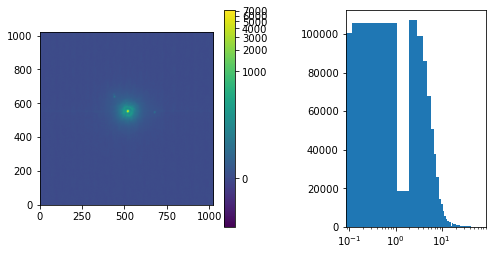

type 'skip' to skip, else type 'go': go


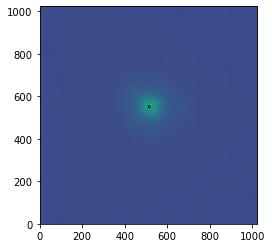

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
516.6254243808178 551.3023738487482 0.21931947941363242
input the 0 indexed integer of your target from the table above: 0
target star is at  516 , 551  at FWHM 6.428226169526624
516 551
give boxsize: 451
516.1809517493501 551.4893256338257



ValueError: 

In [4]:
for path in tqdm_notebook(darksubs[27:]):
    print('current darksubs ind is '+str(darksubs.index(path)))
    # read in darksub cube
    hdr = fits.getheader(path)
    data = fits.getdata(path)
    datadir = path.replace(path.split('\\')[-1], '')
    filname = path.split('\\')[-1]

    # list to store images needed to handle Woll-on images
    # if beamsplitter is on, split images into separate frames, add to images list
    # else, put image in images list
    if hdr['VWOLLSTN'] == 'IN':
        if data.shape[1] >= 1024:
            ha = data[:, 513:, :]
            ha_off = data[:, 0:512, :]
            images = [ha, ha_off]
    else:
        images = [data]
        
    # register images
    for image in images:
        # create guess, boxsize for center of image for registration
        imgandhist(image[0], log=True)
        skip = input('type \'skip\' to skip, else type \'go\': ')
        if skip != 'skip':
            cenx, ceny, fwhm = findFirst('blah', thresh=1000, fwhmguess=5, bright=5, roundness=1, data=image[0])
            print(cenx, ceny)
            nhalf = int(50)
            boxsize = int(input('give boxsize: '))
            n = len(image)
            # coarse registration
            coarse = np.zeros((n, image.shape[1], image.shape[2]))
            for i in range(n):
                frame = image[i]
                xsh, ysh = centroid(frame, cenx, ceny, nhalf=nhalf, derivshift=1.)
                coarse[i, :, :] = shift_image(frame, xsh, ysh)
            
            #coarse = crosscube(image, centerg[0], centerg[1], box=boxsize, returnmed=False, returncube=True)
            #fits.writeto('test2.fit', test, fits.getheader(path), overwrite=True)
            
            imgandhist(np.nanmedian(coarse, axis=0), log=True)

            # fine registration
            fine = circlesym(datadir, filname, 'circlesym.fit', data=coarse, box=boxsize, center = [cenx, ceny], center_only=boxsize//2, save=False)
            hdr = fits.getheader(path)
            hdr.append(('COMMENT', 'aligned with crosscorrelation and center of circular symmetry'), end=True)

            # subdivide observation
            n = len(fine)
            start = 0
            if n > 100:
                sections = n // int(str(n)[0])
                stop = sections
            else:
                sections = n
                stop = sections
            print('subdiv into sections len: '+str(sections))
            subdiv_stack = np.zeros((n, fine.shape[1], fine.shape[2]))
            for i in range(int(str(n)[0])):
                subdiv = fine[start:stop]
                subdiv_stack[i, :, :] = np.nanmedian(subdiv, axis=0)
                newpath = datadir+filname.replace('.fit', '_subdivtest'+str(i)+'.fit')
                fits.writeto(newpath, subdiv_stack[i, :, :], hdr, overwrite=True)
                start += sections
                stop += sections
        else:
            pass

In [3]:
newpath

'Theta1_Ori_C_2014-11-10_darksub_cube_subdivtest4.fit'

In [31]:
# coarse registration
test = crosscube(fits.getdata(path), 512, 512, box=250, returnmed=False, returncube=True)
fits.writeto('test2.fit', test, fits.getheader(path), overwrite=True)

# fine registration
test3 = circlesym('.\\', 'test2.fit', 'test3.fit', box=451, center_only=101)

# subdivide observation
n = len(test3)
sections = n//5
start = 0
stop = sections
subdiv_stack = np.zeros((n, test3.shape[1], test3.shape[2]))
head = fits.getheader(path)
for i in range(5):
    subdiv = test3[start:stop]
    subdiv_stack[i, :, :] = np.nanmedian(subdiv, axis=0)
    fits.writeto('subdivtest'+str(i)+'.fit', subdiv_stack[i, :, :], head, overwrite=True)
    start += sections
    stop += sections

C:\Users\willi\Dropbox (Amherst College)\Research\Follette-Lab\Thesis-Data\William\trapezium_data\visao_astro\visao_20180426_27\tet1OriB_rp_001\Theta1_Ori_B_2018-04-26_darksub_cube.fit


['.\\subdivtest0.fit', '.\\subdivtest1.fit', '.\\subdivtest2.fit', '.\\subdivtest3.fit', '.\\subdivtest4.fit']
Choose a reference star image to create a reference PSF from


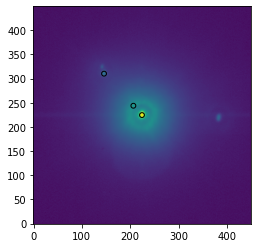

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
224.37216505739164 224.50339618722177 0.19185394186013263
 206.5701424077442 243.83473951757685  0.2349871379067214
145.84874438356388  310.1972370535173 0.26784253140582454
input the 0 indexed integer of your target from the table above: 0
target star is at  224 , 224  at FWHM 5.728300927142357


C:\Users\willi\Amherst\Thesis\Code\diskShapers\astroCalib\calibFuncs.py:1179: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(epsf.data, cmap='inferno', origin='lower', norm=norm,


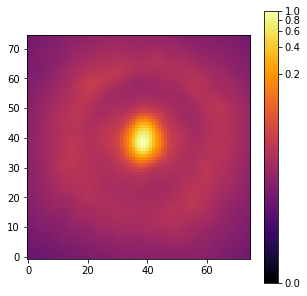

Select your target system to fit positions to


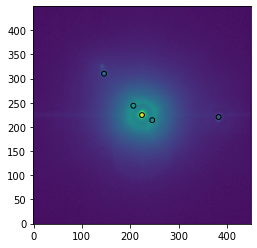

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
245.56673245157518   214.065626996949   0.426049885855797
 382.9243288283576 220.52860589052545 0.31208057572076797
224.37216505739164 224.50339618722177 0.19185394186013263
 206.5701424077442 243.83473951757685  0.2349871379067214
145.84874438356388  310.1972370535173 0.26784253140582454
input the 0 indexed integer of your target from the table above: 4
target star is at  145 , 310  at FWHM 5.257747273696054
Stars found at positions
       x_0               y_0       
----------------- -----------------
38.96957131287477 38.45045324729258
found fewer than 2 stars! re-enter threshold? >15
Stars found at positions
       x_0               y_0       
----------------- -----------------
38.96957131287477 38.45045324729258
       x_0               y_0        
----------------- ------------------
35.10369638847195 52.763782422972675

14.831285222842693 +/- 0.13645272741642994


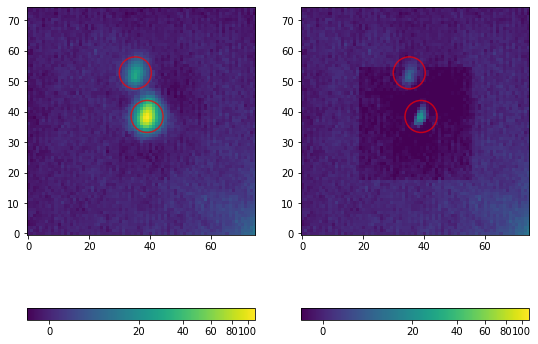

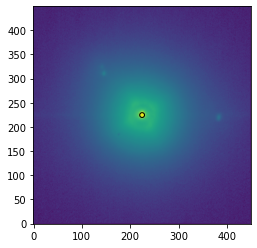

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
224.63711779802912 224.51936677433895 0.18212329717023149


KeyboardInterrupt: Interrupted by user

In [3]:
data_frames = []
for dataset in [glob.glob('.\\subdivtest*.fit*')]:
    print(dataset)
    data = []
    dates = []
    filts = []
    for image in dataset:
        phot_results = VisAOLocate(image, 30, 5, 5, stampsize=75, epsfstamp=75, roundness=1,
                                  iterations=2, crit_sep=5, setfwhm=5, background_sloped=[5,5])
        data.append(phot_results)
        hdr = fits.getheader(image)
        date = hdr['DATE']
        if hdr['VFW1POS'] == 0.0:
                if hdr['VFW2POS'] == 0.0:
                    passband = hdr['VFW3POSN'].replace(' ','-')
                else:
                    passband = hdr['VFW2POSN'].replace('\'', 'prime')
        else:
            passband = hdr['VFW1POSN']
        dates.append(date)
        filts.append(passband)
    data2 = np.asarray(data)
    data_frame = pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr'])
    data_frame['date'] = dates
    data_frame['filter'] = filts
    data_frames.append(data_frame)

In [28]:
data_frames

[         sep      seperr          PA       PAerr                 date filter
 0  14.831285    0.136453   14.801224   -1.555192  2018-04-26T23:13:40     r'
 1  14.030538  287.122145  198.506523 -174.985487  2018-04-26T23:13:40     r'
 2  14.686364    0.150975   14.816989   -1.728516  2018-04-26T23:13:40     r'
 3  14.454096    0.072798   15.670551   -1.090959  2018-04-26T23:13:40     r'
 4  14.531896    0.133807   15.335641   -1.575980  2018-04-26T23:13:40     r']

In [29]:
data_frames[0].to_clipboard()